# COCT Data Scientist Code Challenge

In [2]:
# Imports
import requests
import gzip
import shutil
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


## Get Data
Download the data.

In [3]:
def download_file(url, filename):
    try:
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        response.raise_for_status()  # Raises an HTTPError for bad responses
        
        with open(filename, "wb") as file, tqdm(
            desc=filename,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
                pbar.update(len(chunk))
        
        print(f"Downloaded: {filename}")
        return True
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return False
    
def uncompress_file(compressed_filename, uncompressed_filename):
    with gzip.open(compressed_filename, 'rb') as f_in:
        with open(uncompressed_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    print(f"Uncompressed: {compressed_filename} to {uncompressed_filename}")
    return True

In [4]:
DATA_URL = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/sr_hex.csv.gz"
COMPRESSED_FILE_NAME = "sr_hex.csv.gz"
UNCOMPRESSED_FILE_NAME = "sr_hex.csv"

download_file(DATA_URL, COMPRESSED_FILE_NAME)

uncompress_file(COMPRESSED_FILE_NAME, UNCOMPRESSED_FILE_NAME)

sr_hex.csv.gz: 100%|██████████| 35.0M/35.0M [00:04<00:00, 7.77MB/s]


Downloaded: sr_hex.csv.gz
Uncompressed: sr_hex.csv.gz to sr_hex.csv


True

## Initial Data Exploration

* Print head
* Print info


In [10]:
# Load into Dataframe and print head
df = pd.read_csv('sr_hex.csv')
df.head()

,notification_number,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index
0,400583534,9.109492e+09,2020-10-07 06:55:18+02:00,2020-10-08 15:36:35+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area Central,District: Blaauwberg,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Wear and tear,MONTAGUE GARDENS,-33.872839,18.522488,88ad360225fffff
1,400555043,9.108995e+09,2020-07-09 16:08:13+02:00,2020-07-14 14:27:01+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,SOMERSET WEST,-34.078916,18.848940,88ad36d5e1fffff
2,400589145,9.109614e+09,2020-10-27 10:21:59+02:00,2020-10-28 17:48:15+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,STRAND,-34.102242,18.821116,88ad36d437fffff
3,400538915,9.108601e+09,2020-03-19 06:36:06+02:00,2021-03-29 20:34:19+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area North,District : Bellville,TD Customer complaint groups,Paint Markings Lines&Signs,Road Markings,Wear and tear,RAVENSMEAD,-33.920019,18.607209,88ad361133fffff
4,400568554,NaN,2020-08-25 09:48:42+02:00,2020-08-31 08:41:13+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area South,District : Athlone,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Surfacing failure,CLAREMONT,-33.987400,18.453760,88ad361709fffff


In [11]:
# Print DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941634 entries, 0 to 941633
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   notification_number   941634 non-null  int64  
 1   reference_number      592920 non-null  float64
 2   creation_timestamp    941634 non-null  object 
 3   completion_timestamp  929442 non-null  object 
 4   directorate           932199 non-null  object 
 5   department            932180 non-null  object 
 6   branch                913233 non-null  object 
 7   section               848509 non-null  object 
 8   code_group            941634 non-null  object 
 9   code                  941634 non-null  object 
 10  cause_code_group      131117 non-null  object 
 11  cause_code            129669 non-null  object 
 12  official_suburb       729221 non-null  object 
 13  latitude              729270 non-null  float64
 14  longitude             729270 non-null  float64
 15  

### Discussion
We see there are 941,634 entries in the dataset, with 16 data columns. 
Several columns contain null values (e.g. reference_number, completion_timestamp, cause_code_group).

### Group DF by Hex

Number of unique hex cells: 2083
Average number of service requests per hex: 452.06

Top 5 hex cells by number of service requests:
h3_level8_index
0                  212364
88ad3612a9fffff      3815
88ad361009fffff      3464
88ad368985fffff      3393
88ad361519fffff      2797
dtype: int64

Average number of service requests per hex (zero excluded): 350.27
Median of hex counts (zero excluded): 160.0


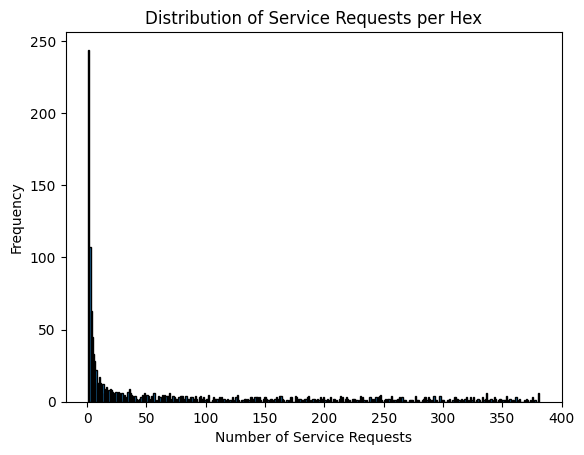

In [16]:
# Group by h3_level8_index and get basic statistics
hex_groups = df.groupby('h3_level8_index')

# Display basic information about the grouped data
print(f"Number of unique hex cells: {len(hex_groups)}")
print(f"Average number of service requests per hex: {len(df) / len(hex_groups):.2f}")

# Show first few groups with their counts
hex_counts = hex_groups.size().sort_values(ascending=False)
print("\nTop 5 hex cells by number of service requests:")
print(hex_counts.head(5))

# Drop the '0' hex cell
df_no_zero = df[df['h3_level8_index'] != '0']
hex_groups_no_zero = df_no_zero.groupby('h3_level8_index')
print(f"\nAverage number of service requests per hex (zero excluded): {len(df_no_zero) / len(hex_groups_no_zero):.2f}")

# Get Median service requests per hex
median_service_requests_per_hex = df_no_zero.groupby('h3_level8_index').size().median()
print(f"Median of hex counts (zero excluded): {median_service_requests_per_hex}")

hex_counts_no_zero = hex_groups_no_zero.size().sort_values(ascending=False)

# Plot a histogram of the number of service requests per hex
plt.hist(hex_counts_no_zero, bins=range(1, max(hex_counts_no_zero // 10) + 1), edgecolor='black')
plt.title('Distribution of Service Requests per Hex')
plt.xlabel('Number of Service Requests')
plt.ylabel('Frequency')
plt.show()

### Discussion
There are 2082 unique hex cells. 
The most frequently occuring one is labled '0' and referse to service request that were not assigned a hex. 
The top 4 valid hex values have between 2797 and 3815 service requests.  
At first it seems on average a hex has 452 service requests.
But this is being skewed by the '0' hex. 
When we exclude the '0' hex we see the mean number of service requests per hex is actually 350 and the median is 160. 